In [86]:
import numpy as np
import pandas as pd
import copy

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.models.detection import transform
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import max_pool2d
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import RandomChoice

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [87]:
batch_size = 32
epochs_number = 200
patience = 5

In [88]:
#Create dataset
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [89]:
#Model
class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier,self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
         
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        output = self.fc4(x)
        
        return output

In [90]:
model = CardClassifier(num_classes=53)
print(model)

CardClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=53, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
)


In [91]:
#Loss Function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [92]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((128, 128)), #Resize to 128x128
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_folder = r'C:\Users\piotr\Desktop\data\train'
valid_folder = r'C:\Users\piotr\Desktop\data\valid'
test_folder = r'C:\Users\piotr\Desktop\data\test'

train_dataset = PlayingCardDataset(train_folder, transform=transform_train)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [93]:
# Early stopping

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = float('inf')
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = "Stopping training"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [95]:
num_epochs = epochs_number
train_losses, val_losses = [], []

model = CardClassifier(num_classes=53)
model.to(device)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4) #Ponad 100 epok zalecany scheduler
es = EarlyStopping(patience=patience)

epoch = 0
done = False
while epoch < num_epochs and not done:
    epoch += 1
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    
    # Aktualizacja harmonogramu
    scheduler.step(val_loss)
     # Check early stopping criteria
    done = es(model, val_loss)
    print(f"Early Stopping: {es.status}")

C:\Users\piotr\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/200 - Train loss: 3.959302485677153, Validation loss: 3.94018089366409
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/200 - Train loss: 3.925210626027767, Validation loss: 3.8906699153612245
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/200 - Train loss: 3.883672258911453, Validation loss: 3.8304972828559154
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/200 - Train loss: 3.839983952883533, Validation loss: 3.7609872242189804
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/200 - Train loss: 3.7812328879005137, Validation loss: 3.664757425380203
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/200 - Train loss: 3.721450411385279, Validation loss: 3.561421779416642
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/200 - Train loss: 3.639518783825517, Validation loss: 3.4297213590370035
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/200 - Train loss: 3.5514688611906196, Validation loss: 3.275838671090468
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/200 - Train loss: 3.4491266013442656, Validation loss: 3.1167467459192815
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/200 - Train loss: 3.3636205456564583, Validation loss: 2.9775847524966834
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/200 - Train loss: 3.261698110156144, Validation loss: 2.8354777767973127
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/200 - Train loss: 3.178665417814305, Validation loss: 2.6873749103186264
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/200 - Train loss: 3.081043338225246, Validation loss: 2.5554953764069754
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/200 - Train loss: 2.9994747518617486, Validation loss: 2.434223957781522
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/200 - Train loss: 2.931266325343193, Validation loss: 2.3159394426165885
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/200 - Train loss: 2.8745753800130966, Validation loss: 2.2492935531544234
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/200 - Train loss: 2.795445571290984, Validation loss: 2.1472619506548036
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/200 - Train loss: 2.749591207704414, Validation loss: 2.0917640587068953
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/200 - Train loss: 2.705986455755244, Validation loss: 2.045773938916764
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/200 - Train loss: 2.6351269677453377, Validation loss: 1.9814709474455636
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/200 - Train loss: 2.5985557510119794, Validation loss: 1.9504542818609274
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/200 - Train loss: 2.54343651574406, Validation loss: 1.8769028636644471
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/200 - Train loss: 2.5052203529153765, Validation loss: 1.8509306205893463
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/200 - Train loss: 2.4835355241801533, Validation loss: 1.8125971632183722
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/200 - Train loss: 2.415737356744308, Validation loss: 1.7486179945603857
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/200 - Train loss: 2.398477007184424, Validation loss: 1.7295258589510647
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/200 - Train loss: 2.369248219076759, Validation loss: 1.7051543289760374
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/200 - Train loss: 2.3378840048190552, Validation loss: 1.6873075728146536
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/200 - Train loss: 2.3088333494140367, Validation loss: 1.660029478343028
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/200 - Train loss: 2.2792742062215416, Validation loss: 1.6244712109835642
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/200 - Train loss: 2.262458196341804, Validation loss: 1.597297864590051
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/200 - Train loss: 2.216294800997531, Validation loss: 1.578716523692293
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/200 - Train loss: 2.1951582331722457, Validation loss: 1.5526059150695801
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/200 - Train loss: 2.176544100640328, Validation loss: 1.5263361080637519
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/200 - Train loss: 2.1515707960909336, Validation loss: 1.5117965567786738
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/200 - Train loss: 2.120818137121851, Validation loss: 1.4938352494869591
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/200 - Train loss: 2.1043271853315866, Validation loss: 1.4781902232260073
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/200 - Train loss: 2.0692683827339162, Validation loss: 1.4446090545294419
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/200 - Train loss: 2.0558908926352375, Validation loss: 1.4232184671006112
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/200 - Train loss: 2.03752359175607, Validation loss: 1.4133736511446395
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/200 - Train loss: 2.021564832889521, Validation loss: 1.3863996460752668
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/200 - Train loss: 1.9900257574924016, Validation loss: 1.3677473045744986
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/200 - Train loss: 1.971432526239193, Validation loss: 1.3588981704891852
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/200 - Train loss: 1.944535515115744, Validation loss: 1.3252759807514694
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/200 - Train loss: 1.9293433028778524, Validation loss: 1.3206985838008376
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/200 - Train loss: 1.8956493035443558, Validation loss: 1.2897133449338518
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/200 - Train loss: 1.8837969351915598, Validation loss: 1.2965011088353282
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/200 - Train loss: 1.8582025770125334, Validation loss: 1.2547990547036225
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/200 - Train loss: 1.8380343233550833, Validation loss: 1.2483923147309501
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/200 - Train loss: 1.8126510635628155, Validation loss: 1.2316756037046324
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/200 - Train loss: 1.806187624946346, Validation loss: 1.2108544763529077
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/200 - Train loss: 1.7885667139435615, Validation loss: 1.1949237589566213
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/200 - Train loss: 1.7571711505197403, Validation loss: 1.172609634669322
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/200 - Train loss: 1.736560797140956, Validation loss: 1.1483118646549728
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/200 - Train loss: 1.7101019105530986, Validation loss: 1.1265160610091012
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/200 - Train loss: 1.6993414835314435, Validation loss: 1.1225391626358032
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/200 - Train loss: 1.6520889218181278, Validation loss: 1.0957276335302388
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/200 - Train loss: 1.6445717363767833, Validation loss: 1.0877580615709412
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/200 - Train loss: 1.625626381709468, Validation loss: 1.0495554699088043
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/200 - Train loss: 1.6034211353139887, Validation loss: 1.0450849128219317
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/200 - Train loss: 1.581405590738855, Validation loss: 1.0292249099263604
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/200 - Train loss: 1.564551386853205, Validation loss: 1.0064278625092415
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/200 - Train loss: 1.5422288030542333, Validation loss: 1.0456639348335985
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/200 - Train loss: 1.5469899427728162, Validation loss: 0.9842049562706138
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/200 - Train loss: 1.5134229428620554, Validation loss: 0.9768378046323668
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/200 - Train loss: 1.49295878197689, Validation loss: 0.9657701465318788
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/200 - Train loss: 1.480040750623625, Validation loss: 0.9487949578267223
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/200 - Train loss: 1.4425796326660285, Validation loss: 0.9242860915525904
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/200 - Train loss: 1.4349324633167022, Validation loss: 0.9068180862462746
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/200 - Train loss: 1.4316411206004251, Validation loss: 0.9034549186814506
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/200 - Train loss: 1.4207645455787714, Validation loss: 0.8969671033463388
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/200 - Train loss: 1.3965767368064472, Validation loss: 0.8712904714188485
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/200 - Train loss: 1.379394051660896, Validation loss: 0.8594899924296253
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/200 - Train loss: 1.3562421946310421, Validation loss: 0.8482304640536038
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/200 - Train loss: 1.330133848025191, Validation loss: 0.8452920594305362
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/200 - Train loss: 1.3261748726195328, Validation loss: 0.8133566694439582
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/200 - Train loss: 1.29839104470276, Validation loss: 0.8540522359452157
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/200 - Train loss: 1.2944451367242138, Validation loss: 0.8158621608086352
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/200 - Train loss: 1.263471397247795, Validation loss: 0.7956207077458219
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80/200 - Train loss: 1.256186221822987, Validation loss: 0.7752919161094809
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81/200 - Train loss: 1.2467891097944406, Validation loss: 0.7647928674266024
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82/200 - Train loss: 1.2285369104253283, Validation loss: 0.7698340784828618
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83/200 - Train loss: 1.2155569063153622, Validation loss: 0.7536573657449687
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84/200 - Train loss: 1.1967865491338692, Validation loss: 0.732384531902817
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85/200 - Train loss: 1.1671426521393335, Validation loss: 0.7373908272329367
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86/200 - Train loss: 1.1634766363772364, Validation loss: 0.7205181513192519
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87/200 - Train loss: 1.1514819580260254, Validation loss: 0.7145989107635786
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88/200 - Train loss: 1.1531032627176763, Validation loss: 0.692263522687948
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89/200 - Train loss: 1.131622994058655, Validation loss: 0.703429205912464
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90/200 - Train loss: 1.1083963351384791, Validation loss: 0.7040598860326803
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91/200 - Train loss: 1.0857579748127668, Validation loss: 0.7007140735410294
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92/200 - Train loss: 1.0700500583098294, Validation loss: 0.6747147546624238
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93/200 - Train loss: 1.0619189904344044, Validation loss: 0.6754829523698339
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94/200 - Train loss: 1.0452806843290299, Validation loss: 0.6238944579970161
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95/200 - Train loss: 1.0397650577589197, Validation loss: 0.6326885205394817
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96/200 - Train loss: 1.0258203882798318, Validation loss: 0.6281421175542867
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97/200 - Train loss: 1.0051531662845912, Validation loss: 0.617004768128665
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98/200 - Train loss: 1.0036118944319197, Validation loss: 0.6118643427794834
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99/200 - Train loss: 0.9954627839865989, Validation loss: 0.5959349177918344
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100/200 - Train loss: 0.9756704565110261, Validation loss: 0.6423339034026524
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 101/200 - Train loss: 0.9720415095842647, Validation loss: 0.6058596107195009
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 102/200 - Train loss: 0.9474271504288581, Validation loss: 0.5685023642935843
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 103/200 - Train loss: 0.9328746328448949, Validation loss: 0.562860830774847
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 104/200 - Train loss: 0.9256293596650971, Validation loss: 0.5614243554619124
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 105/200 - Train loss: 0.8969321027632651, Validation loss: 0.565816456641791
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 106/200 - Train loss: 0.8937907159047012, Validation loss: 0.542189242255013
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 107/200 - Train loss: 0.8823356893605475, Validation loss: 0.5385675254857765
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 108/200 - Train loss: 0.8763736463293574, Validation loss: 0.5380819932469781
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 109/200 - Train loss: 0.870094644372886, Validation loss: 0.5621091795417498
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 110/200 - Train loss: 0.8612713314678837, Validation loss: 0.5279394250995708
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 111/200 - Train loss: 0.8360422102877125, Validation loss: 0.5353470206260681
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 112/200 - Train loss: 0.8356160110591716, Validation loss: 0.5238444982834582
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 113/200 - Train loss: 0.8219252269390622, Validation loss: 0.5211985367649007
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 114/200 - Train loss: 0.8084631065631839, Validation loss: 0.4956879622531387
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 115/200 - Train loss: 0.796972418631987, Validation loss: 0.5147091692348696
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 116/200 - Train loss: 0.7908934843252489, Validation loss: 0.49597150964557
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 117/200 - Train loss: 0.7773233854758151, Validation loss: 0.5090891174550326
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 118/200 - Train loss: 0.7573761277033675, Validation loss: 0.5548148928948169
Early Stopping: 4/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 119/200 - Train loss: 0.7541248619181161, Validation loss: 0.47680743887739363
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 120/200 - Train loss: 0.7554418570347373, Validation loss: 0.48007183547289867
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 121/200 - Train loss: 0.7401015013612705, Validation loss: 0.4752268964389585
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 122/200 - Train loss: 0.7192215189603544, Validation loss: 0.4636145861643665
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 123/200 - Train loss: 0.7183828451450824, Validation loss: 0.44867461964769184
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 124/200 - Train loss: 0.7090936401958605, Validation loss: 0.44730377647112
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 125/200 - Train loss: 0.6907374319099554, Validation loss: 0.4928812528556248
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 126/200 - Train loss: 0.686744041670532, Validation loss: 0.47789518563252575
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 127/200 - Train loss: 0.6795911753915664, Validation loss: 0.46639747349721083
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 128/200 - Train loss: 0.6779010587324, Validation loss: 0.4887134648718924
Early Stopping: 4/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 129/200 - Train loss: 0.6518723983923511, Validation loss: 0.4558048301147965
Early Stopping: Stopping training


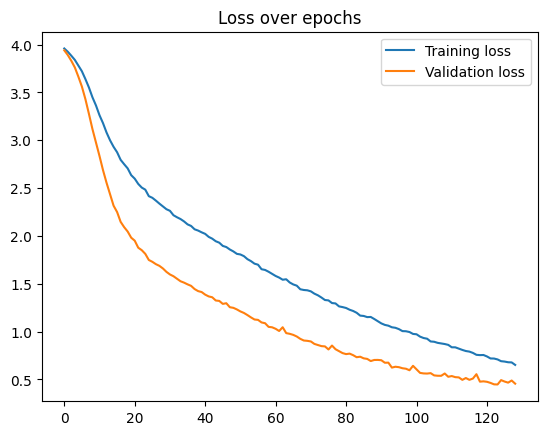

In [96]:
#Visualize Losses

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [97]:
# Calculate the Accuracy of the Model using test data

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 85.66%


In [98]:
#torch.save(model.state_dict(), "card_classifier93.96%.pth")

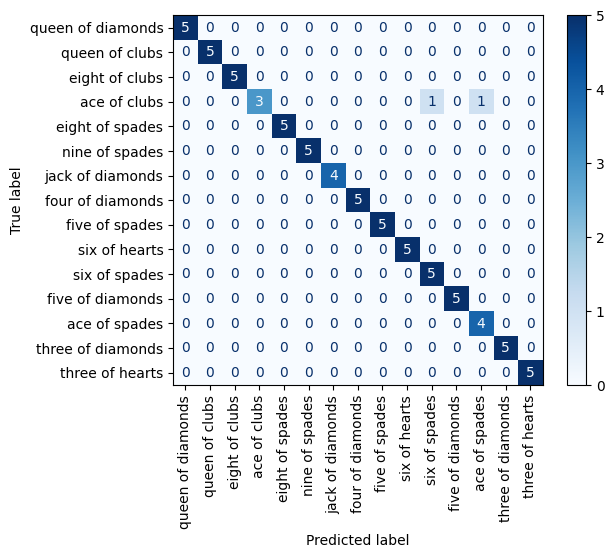

In [99]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Identify the top 10 classes based on prediction frequency
top_n_classes = np.argsort(np.bincount(predicted_labels))[::-1][:15]

# Extract the relevant rows and columns from the confusion matrix
conf_matrix_top_n = conf_matrix[top_n_classes][:, top_n_classes]

# Get the class names for the top 10 classes
class_names_top_n = [train_dataset.classes[i] for i in top_n_classes]

# Display the confusion matrix for the top 10 classes with rotated labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_top_n, display_labels=class_names_top_n)
disp.plot(cmap='Blues', values_format='d', xticks_rotation=90)
plt.show()